In [1]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from vgg_cifar import vgg

import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Set the random seed

In [2]:
seed = 5
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define functions

In [3]:
def train(train_loader, model, criterion, optimizer, epoch, is_cpu, is_half, print_freq):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        if is_cpu == False:
            input = input.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)
        if is_half:
            input = input.half()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))


def validate(val_loader, model, criterion, is_cpu, is_half, print_freq):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        if is_cpu == False:
            input = input.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

        if is_half:
            input = input.half()

        # compute output
        with torch.no_grad():
            output = model(input)
            loss = criterion(output, target)

        output = output.float()
        loss = loss.float()

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses,
                      top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))


    return top1.avg


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(lr, optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 2 every 30 epochs"""
    new_lr = lr * (0.5 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [4]:
def run_train(args):
    if args.dataset == "cifar10" :
        num_classes = 10
    elif args.dataset == "cifar100" :
        num_classes = 100
    print("dataset : ", args.dataset)
    print("num classes : ", num_classes)

    # Check the save_dir exists or not
    save_path = os.path.join(args.save_dir, args.dataset, args.block)
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    model = vgg.__dict__[args.arch](num_classes, args.block)

    model.features = torch.nn.DataParallel(model.features)
    if args.cpu:
        model.cpu()
    else:
        model.cuda()

    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.evaluate, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    # cudnn.benchmark = False

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    if args.dataset == "cifar10":
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)

        val_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)
    elif args.dataset == "cifar100" :
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)

        val_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)
    

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss()
    if args.cpu:
        criterion = criterion.cpu()
    else:
        criterion = criterion.cuda()

    if args.half:
        model.half()
        criterion.half()

    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)    

    if args.evaluate:
        validate(val_loader, model, criterion, args.cpu, args.half, args.print_freq)
        return

    best_prec1 = 0
    accu_prec1 = []
    for epoch in range(args.start_epoch, args.epochs):
        adjust_learning_rate(args.lr, optimizer, epoch)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch, args.cpu, args.half, args.print_freq)

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion, args.cpu, args.half, args.print_freq)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best, filename=os.path.join(save_path, 'checkpoint_{}.tar'.format(epoch)))
        
        # Accumulated precisions
        accu_prec1.append(prec1)
    
    return accu_prec1

## Define hyper-parameters

In [5]:
class Agrument:
    def __init__(self):
        self.arch = 'vgg19_bn'  #  Choice : 'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn'
        self.workers = 4
        self.epochs = 300
        self.start_epoch = 0
        self.batch_size = 128
        self.lr = 0.05
        self.momentum = 0.9
        self.weight_decay = 5e-4
        self.print_freq = 20
        self.resume = ''
        self.evaluate = False
        self.pretrained = False
        self.half = False
        self.cpu = False
        self.save_dir = 'save_temp'
        self.dataset = 'cifar10'  # Choice : 'cifar10' and 'cifar100'
        self.block = 'VGG19'

args = Agrument()

## Model training

In [6]:
block_list = ['VGG19', 'SE_SA_1', 'SEC_SA_1', 'CBAM_1', 'NEW_1']
name_list = ['VGG19 (base)', 'SE (residuel) + SA', 'SE + SA', 'CBAM', 'Our model']
color_list = ['r', 'y', 'b', 'm', 'g']

In [7]:
accuracy_list = []
for bt, bn in zip(block_list, name_list):
    print()
    print('########################################################################################')
    print('Training of %s' %bn)
    args.block = bt
    accuracy_list.append(run_train(args))
    print('########################################################################################')


################################################################
Training of VGG19 (base)
dataset :  cifar10
num classes :  10
features :  Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool

Files already downloaded and verified
Epoch: [0][0/391]	Time 7.166 (7.166)	Data 6.867 (6.867)	Loss 2.3310 (2.3310)	Prec@1 10.938 (10.938)
Epoch: [0][20/391]	Time 0.032 (0.373)	Data 0.000 (0.327)	Loss 2.2366 (2.3192)	Prec@1 19.531 (11.161)
Epoch: [0][40/391]	Time 0.032 (0.206)	Data 0.001 (0.168)	Loss 2.0263 (2.2388)	Prec@1 25.000 (14.615)
Epoch: [0][60/391]	Time 0.031 (0.149)	Data 0.000 (0.113)	Loss 1.9874 (2.1822)	Prec@1 17.969 (15.958)
Epoch: [0][80/391]	Time 0.035 (0.120)	Data 0.000 (0.085)	Loss 2.0160 (2.1296)	Prec@1 18.750 (17.602)
Epoch: [0][100/391]	Time 0.030 (0.103)	Data 0.000 (0.068)	Loss 1.9233 (2.0911)	Prec@1 23.438 (18.866)
Epoch: [0][120/391]	Time 0.032 (0.091)	Data 0.000 (0.057)	Loss 1.9443 (2.0622)	Prec@1 18.750 (19.854)
Epoch: [0][140/391]	Time 0.030 (0.082)	Data 0.001 (0.049)	Loss 1.9649 (2.0332)	Prec@1 23.438 (20.972)
Epoch: [0][160/391]	Time 0.031 (0.076)	Data 0.000 (0.043)	Loss 1.8304 (2.0069)	Prec@1 27.344 (21.967)
Epoch: [0][180/391]	Time 0.032 (0.071)	Data 0.000 

Epoch: [0][260/391]	Time 0.031 (0.057)	Data 0.000 (0.026)	Loss 1.5116 (1.8680)	Prec@1 40.625 (27.356)
Epoch: [0][280/391]	Time 0.031 (0.055)	Data 0.000 (0.024)	Loss 1.6554 (1.8540)	Prec@1 36.719 (28.086)
Epoch: [0][300/391]	Time 0.031 (0.053)	Data 0.000 (0.022)	Loss 1.6729 (1.8388)	Prec@1 42.969 (28.740)
Epoch: [0][320/391]	Time 0.031 (0.052)	Data 0.000 (0.021)	Loss 1.6773 (1.8268)	Prec@1 36.719 (29.237)
Epoch: [0][340/391]	Time 0.031 (0.051)	Data 0.000 (0.020)	Loss 1.5171 (1.8135)	Prec@1 43.750 (29.834)
Epoch: [0][360/391]	Time 0.031 (0.050)	Data 0.000 (0.019)	Loss 1.7413 (1.7979)	Prec@1 35.156 (30.566)
Epoch: [0][380/391]	Time 0.031 (0.049)	Data 0.001 (0.018)	Loss 1.6070 (1.7840)	Prec@1 33.594 (31.150)
Test: [0/79]	Time 5.521 (5.521)	Loss 1.6644 (1.6644)	Prec@1 38.281 (38.281)
Test: [20/79]	Time 0.011 (0.279)	Loss 1.6869 (1.5746)	Prec@1 32.812 (40.253)
Test: [40/79]	Time 0.009 (0.148)	Loss 1.5524 (1.5674)	Prec@1 37.500 (39.863)
Test: [60/79]	Time 0.010 (0.102)	Loss 1.3633 (1.5661)	Pr

Files already downloaded and verified
Epoch: [0][0/391]	Time 7.006 (7.006)	Data 6.720 (6.720)	Loss 2.3390 (2.3390)	Prec@1 10.156 (10.156)
Epoch: [0][20/391]	Time 0.032 (0.365)	Data 0.000 (0.320)	Loss 2.2684 (2.3097)	Prec@1 14.844 (11.868)
Epoch: [0][40/391]	Time 0.030 (0.202)	Data 0.000 (0.164)	Loss 2.0955 (2.2662)	Prec@1 14.844 (14.177)
Epoch: [0][60/391]	Time 0.032 (0.146)	Data 0.000 (0.110)	Loss 2.0334 (2.2087)	Prec@1 18.750 (16.227)
Epoch: [0][80/391]	Time 0.032 (0.118)	Data 0.001 (0.083)	Loss 1.9769 (2.1583)	Prec@1 28.125 (17.901)
Epoch: [0][100/391]	Time 0.032 (0.101)	Data 0.000 (0.067)	Loss 2.0378 (2.1151)	Prec@1 21.094 (18.967)
Epoch: [0][120/391]	Time 0.032 (0.090)	Data 0.001 (0.056)	Loss 1.9458 (2.0811)	Prec@1 25.781 (20.209)
Epoch: [0][140/391]	Time 0.032 (0.081)	Data 0.000 (0.048)	Loss 1.8434 (2.0518)	Prec@1 29.688 (21.188)
Epoch: [0][160/391]	Time 0.033 (0.075)	Data 0.000 (0.042)	Loss 1.7203 (2.0236)	Prec@1 32.031 (22.234)
Epoch: [0][180/391]	Time 0.031 (0.070)	Data 0.000 

## Display the accuracy of models

[1]


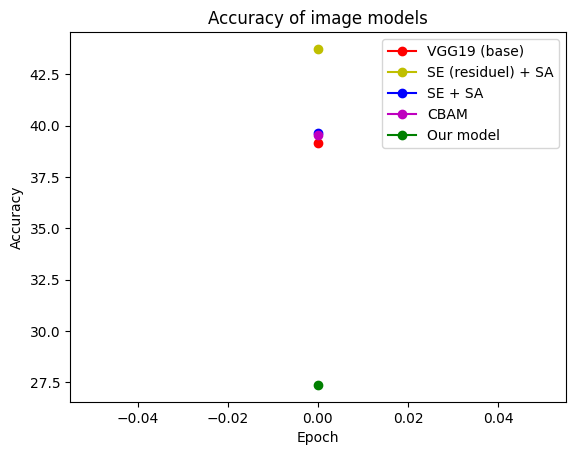

In [18]:
plt.figure()
x = [i+1 for i in range(len(accuracy_list[0]))]
print(x)
for ba, bn, bc in zip(accuracy_list, name_list, color_list):
    plt.plot(ba, label = bn, color = bc, marker='o')
#plt.xlim([0, 5])      # X축의 범위: [xmin, xmax]
#plt.ylim([0, 20])     # Y축의 범위: [ymin, ymax]
plt.title('Accuracy of image models')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()